In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-msssim

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [4]:
from math import floor
import numpy as np
from pytorch_msssim import ms_ssim
from torchvision.models.inception import inception_v3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
inception_model = inception_v3(pretrained=True, transform_input=False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [6]:
def calculate_inception_score(images,inception_model,n_split=10, eps=1E-16):
  inception_model.eval()
  up = nn.Upsample(size=(299,299), mode='bilinear',align_corners=False)
  images = up(images)
  yhat = F.softmax(inception_model(images))
  scores = list()
  n_part = floor(images.shape[0]/n_split)
  for i in range(n_split):
    ix_start, ix_end = i * n_part, i * n_part + n_part
    p_yx = yhat[ix_start:ix_end]
    p_y = p_yx.mean(dim=0).unsqueeze(0)
    kl_d = p_yx * (p_yx.log() - p_y.log())
    sum_kl_d = kl_d.sum(dim=1)
    avg_kl_d = sum_kl_d.mean()
    score = avg_kl_d.exp()
    scores.append(score.item())
  avg = np.mean(scores)
  std = np.std(scores)
  return avg, std

In [7]:
def generate_images_calculate_IS(gen_model, target, nz, inception_model,total_number_of_images = 256):
  gen_model.to('cpu')
  class_target = torch.tensor([target])
  with torch.no_grad():
      latent_z = torch.randn(total_number_of_images, nz)
      latent_z[:,-10:]=F.one_hot(class_target, num_classes=10)
      fake_img = gen_model(latent_z)

  avg, std = calculate_inception_score(fake_img,inception_model)
  print('IS avg {:.4f}, IS std {:.4f}'.format(avg, std))

  npimg = make_grid(fake_img, padding=0, nrow=16)
  fig, axes = plt.subplots(1,1, figsize=(10,10))
  axes.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  fig.show()
  
  return fake_img

In [8]:
def cal_ms_ssim(img_real,img_fake):
  up = nn.Upsample(size=(299,299), mode='bilinear',align_corners=False)
  img_real =up(img_real.type(torch.DoubleTensor))
  img_fake =up(img_fake.type(torch.DoubleTensor))

  ms_ssim_score = ms_ssim(img_fake,img_real,data_range=1,size_average=True)
  print('MS_SSIM avg {:.4f}'.format(ms_ssim_score))
  return ms_ssim_score

In [9]:
class ACDiscriminator(nn.Module):
    def __init__(self, nclass=10):
        super(ACDiscriminator, self).__init__()
      
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2,padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),

                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),

                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
            )
            
        self.fc_linear = nn.Linear(8192,  256)
        self.fc_class =  nn.Linear(256, nclass)
        self.fc_isreal = nn.Linear(256, 1)


    def forward(self, input):
        bz=input.size()[0]
        out = self.conv(input)
        out=out.view(bz,-1)
        
        out = self.fc_linear(out)

        fc_class= F.softmax(self.fc_class(out))
        fc_isreal = F.sigmoid(self.fc_isreal(out))
        
        return fc_class, fc_isreal

In [10]:
class ACGenerator(nn.Module):
    def __init__(self, nz):
        super(ACGenerator, self).__init__()
        self.nz=nz
        
        #linear
        self.fc = nn.Linear(self.nz,384)
        
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=384,out_channels=192, kernel_size=4, stride=1,padding=0),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=192,out_channels=96, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=96,out_channels=48, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=48,out_channels=3, kernel_size=4, stride=2,padding=1),
            nn.Tanh()
            )
        
        
    def forward(self, input):
        input = input.view(-1,self.nz)
        out = self.fc(input).view(-1,384,1,1)
        out = self.tconv(out)
       
        return out

In [11]:
def training(iterations, dataloader, dis_model, gen_model, optD, optG, class_loss, label_loss, nz, device):
    eval_z = torch.normal(0, 1, size=(32,nz))
    eval_class = torch.randint(0, 10, (32,))
    eval_z[:,-10:]=F.one_hot(eval_class, num_classes=10)
    eval_z =eval_z.to(device)

    for epoch in range(iterations):
        total_dis_loss=0
        total_gen_loss=0

        for img, class_target in dataloader:
            img = img.to(device)
            class_target = class_target.to(device)

            #train the discriminator
            optD.zero_grad()

            #real data is 1 and fake data is 0
            img_real_label = Variable(torch.ones(img.size()[0],1).to(device))
            img_fake_label = Variable(torch.zeros(img.size()[0],1).to(device))

            img_class_pred, img_label_pred = dis_model(img)
            loss_class_real= class_loss(img_class_pred, class_target)
            loss_label_real= label_loss(img_label_pred, img_real_label)
            loss_dis_real= loss_class_real+loss_label_real
            loss_dis_real.backward()
            optD.step()
            
            latent_z = torch.randn(img.size()[0],nz).to(device)
            class_target_fake =torch.randint(0,10, (img.size()[0],)).to(device)
            latent_z[:,-10:]=F.one_hot(class_target_fake, num_classes=10)

            fake_img = gen_model(latent_z)
            fake_img_class_pred, fake_img_label_pred=dis_model(fake_img.detach())
            
            loss_class_fake = class_loss(fake_img_class_pred, class_target_fake)
            loss_label_fake = label_loss(fake_img_label_pred, img_fake_label)
            loss_dis_fake=loss_class_fake +loss_label_fake
            loss_dis_fake.backward()
            optD.step()

            loss_dis = (loss_dis_fake+loss_dis_real)/2
 
            #train the generator
            gen_model.zero_grad()
            fake_img_class, fake_img_label = dis_model(fake_img)
            
            loss_class_gen = class_loss(fake_img_class, class_target)
            loss_label_gen = label_loss(fake_img_label, img_real_label)
            loss_gen =loss_class_gen +loss_label_gen
            
            loss_gen.backward()
            optG.step()
 
            total_dis_loss+=loss_dis.item()
            total_gen_loss+=loss_gen.item()

        print('Epoch {} Discriminator loss {:.2f} and Generator loss {:.2f}'.format(epoch, total_dis_loss/len(dataloader),total_gen_loss/len(dataloader)))
        with torch.no_grad():
          eval_img = gen_model(eval_z)
          vutils.save_image(eval_img.data, "eval_images_{}.png".format(epoch))
          vutils.save_image(img.data, "eval_real_images_{}.png".format(epoch))


        torch.save(gen_model.state_dict(), '/content/ACGen_epoch_best.pth')
        torch.save(dis_model.state_dict(), '/content/ACDis_epoch_best.pth')

    return 

In [12]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
    nn.init.normal_(m.weight.data, mean=0, std=0.02)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight.data, mean=1, std=0.02)
    nn.init.constant_(m.bias.data, 0)

In [13]:
nz=100
nclass=10

lr=0.0002
iterations=1000

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [14]:
dis_model = ACDiscriminator(nclass).to(device)
gen_model = ACGenerator(nz).apply(initialize_weights).to(device)

label_loss=nn.BCELoss()
class_loss=nn.NLLLoss()

optD = optim.Adam(dis_model.parameters(), lr=lr)
optG = optim.Adam(gen_model.parameters(), lr=lr)

In [15]:
#gen_model = ACGenerator(nz).to(device)
#gen_model.load_state_dict(torch.load('/content/ACGen_epoch_best.pth'))
#gen_model.to(device)
#dis_model = ACDiscriminator(nclass)
#dis_model.load_state_dict(torch.load('/content/ACDis_epoch_best.pth'))
#dis_model.to(device)

training(iterations, trainloader, dis_model, gen_model, optD, optG, class_loss, label_loss, nz, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Discriminator loss 0.02 and Generator loss 7.81
Epoch 1 Discriminator loss -0.04 and Generator loss 6.53
Epoch 2 Discriminator loss -0.05 and Generator loss 5.69
Epoch 3 Discriminator loss -0.03 and Generator loss 5.75
Epoch 4 Discriminator loss 0.02 and Generator loss 4.11
Epoch 5 Discriminator loss -0.01 and Generator loss 4.76
Epoch 6 Discriminator loss -0.01 and Generator loss 4.58
Epoch 7 Discriminator loss -0.03 and Generator loss 4.90
Epoch 8 Discriminator loss -0.05 and Generator loss 5.38
Epoch 9 Discriminator loss -0.05 and Generator loss 5.07
Epoch 10 Discriminator loss -0.08 and Generator loss 6.00
Epoch 11 Discriminator loss -0.04 and Generator loss 5.49
Epoch 12 Discriminator loss -0.07 and Generator loss 6.24
Epoch 13 Discriminator loss -0.07 and Generator loss 6.16
Epoch 14 Discriminator loss -0.09 and Generator loss 6.77
Epoch 15 Discriminator loss -0.05 and Generator loss 5.83
Epoch 16 Discriminator loss -0.06 and Generator loss 5.57
Epoch 17 Discriminator los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IS avg 2.3381, IS std 0.2491
MS_SSIM avg 0.0307


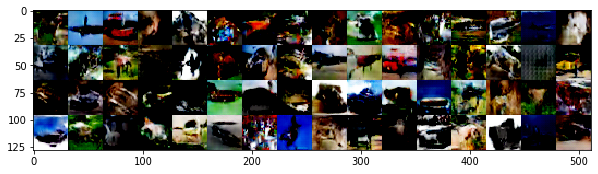

In [23]:
target=9
total_number_of_images = 64

ACGen = ACGenerator(nz)
ACGen.load_state_dict(torch.load('/content/ACGen_epoch_best.pth'))

#select a batch of target
label = np.asarray(trainset.targets)
img=np.asarray(trainset.data/255)
img_real=img[label==target][0:total_number_of_images]
img_real=torch.tensor(img_real).permute(0,3,2,1)


img_fake=generate_images_calculate_IS(ACGen, target, nz, inception_model, total_number_of_images)
vutils.save_image(img_fake.data, "./ac_images_fake_group_{}.png".format(target))
ms_ssim_score = cal_ms_ssim(img_real, img_fake)

In [26]:
target = 0
total_number_of_images = 32

ACGen = ACGenerator(nz)
ACGen.load_state_dict(torch.load('/content/ACGen_epoch_best.pth'))

#select a batch of target
label = np.asarray(trainset.targets)
img=np.asarray(trainset.data/255)
img_real=img[label==target][0:total_number_of_images]
img_real=torch.tensor(img_real).permute(0,3,2,1)

class_target = torch.tensor([target])

latent_z = torch.randn(total_number_of_images, nz) 
latent_z1 = torch.randn(1, nz)
latent_z2 = torch.randn(1, nz)

for index, num in enumerate(torch.linspace(0, 1, 32)):
  latent_z[index] = latent_z1 +(latent_z2-latent_z1)*num

latent_z[:,-10:]=F.one_hot(class_target, num_classes=10)
fake_img = ACGen(latent_z)
vutils.save_image(fake_img.data, "./ac_images_fake_latent.png")